<a href="https://colab.research.google.com/github/sara692/distilbert-base-uncased_Emotions-Classification/blob/main/distilbert_base_uncased_Emotions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.linear_model import LogisticRegression
import torch
import umap as UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from transformers import Trainer, TrainingArguments
from huggingface_hub import notebook_login
from datasets import load_dataset

In [2]:
# Load the dataset ('emotions')
emotion = load_dataset('emotion')
emotion

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# Check the features of the train
print(emotion['train'].features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In [4]:
# Convert to Pandas for visualization and Cleaning
df=emotion.set_format(type='pandas')
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


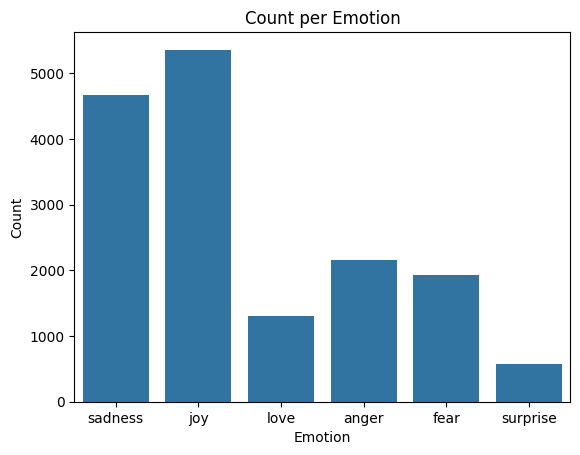

In [5]:
#check the count of sample per class
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

sns.countplot(
    data=df,
    x="label",
    order=emotion_map.keys()
)

plt.xticks(ticks=range(len(emotion_map)),
           labels=emotion_map.values())

plt.title("Count per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [6]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
text     0
label    0
dtype: int64


In [7]:
# check dulicated rows

duplicates = df[df.duplicated(subset=['text','label'], keep=False)]
duplicates_sorted = duplicates.sort_values('text')
print(f"TOTAL DUPLICATE ROWS: {len(duplicates)}")
print("\n" + "="*100)
print("ALL DUPLICATE ROWS (COMPLETE LIST)")
print("="*100)
print(duplicates_sorted.to_string(index=True))

TOTAL DUPLICATE ROWS: 2

ALL DUPLICATE ROWS (COMPLETE LIST)
                                                                 text  label
4975   i feel more adventurous willing to take risks img src http cdn      1
13846  i feel more adventurous willing to take risks img src http cdn      1


In [9]:
df.drop_duplicates(subset=['text','label'], inplace=True)

In [10]:
# check dulicated text data

All_duplicates = df[df.duplicated(subset=['text',], keep=False)]
All_duplicates_sorted = All_duplicates.sort_values('text')
print(f"TOTAL DUPLICATE ROWS: {len(All_duplicates)}")
print("\n" + "="*100)
print("ALL DUPLICATE ROWS (COMPLETE LIST)")
print("="*100)
print(All_duplicates_sorted.to_string(index=True))

TOTAL DUPLICATE ROWS: 60

ALL DUPLICATE ROWS (COMPLETE LIST)
                                                                                                                                                                                          text  label
3508                                                                                                                   i am not amazing or great at photography but i feel passionate about it      1
8246                                                                                                                   i am not amazing or great at photography but i feel passionate about it      2
15705                                                                                                                                        i began to feel accepted by gaia on her own terms      1
5277                                                                                                                                         i bega

In [11]:
# Find texts with conflicting labels
conflict_texts = set()
for text in df[df.duplicated(subset=['text'], keep=False)]['text'].unique():
    if df[df['text'] == text]['label'].nunique() > 1:
        conflict_texts.add(text)

# Remove ALL rows with those texts
df = df[~df['text'].isin(conflict_texts)]
print("After removing all conflicting texts:")
print(df)

After removing all conflicting texts:
                                                    text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[15939 rows x 2 columns]


In [12]:
#return to dict Format
emotion.reset_format()

In [13]:
# Get the model checkPoint and load the tokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def Tokenization(data):
  return tokenizer(data['text'],padding=True,truncation=True,max_length=512,return_tensors='pt')

In [15]:
tokenized_data=emotion.map(Tokenization,batched=True,batch_size=None)
tokenized_data['train'].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

In [16]:
# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The device is: {device}')

The device is: cuda


In [17]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [18]:
# Define the performance metrics
def compute_metrics(pred):
  labels = pred.label_ids  # The Ground Truth
  preds = pred.predictions.argmax(-1)   # The predictions

  # Calculate the f1 & accuracy
  f1 = f1_score(labels, preds, average='weighted')  # It is multiclass
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [19]:
# Prepare the training arguments
batch_size = 32
logging_steps = len(tokenized_data['train']) // batch_size

# a checkpoint name
my_model_chkpt = f'{model_ckpt}-finetuned-depi-before'

# Define some training arguments with updated parameters
training_args = TrainingArguments(
    output_dir=my_model_chkpt,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level='info',
    report_to=["none"]  # Explicitly disable all reporting integrations
)

In [21]:
# Initialize the Trainer API
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_data['train'],
                  eval_dataset=tokenized_data['validation']
                  )
# Start Training
trainer.train();

The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text. If token_type_ids, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16,000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,000
  Number of trainable parameters = 66,958,086


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.131979,0.186142,0.933500,0.934185
2,0.085585,0.154225,0.941000,0.941279


Saving model checkpoint to distilbert-base-uncased-finetuned-depi-before/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/config.json


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model weights saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text. If token_type_ids, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-finetuned-depi-before/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-1000/config.json


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model weights saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-1000/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text. If token_type_ids, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




In [23]:
# Examine the performance of the model on the test dataset
preds_output_test = trainer.predict(tokenized_data['test'])
preds_output_test.predictions.shape

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text. If token_type_ids, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


(2000, 6)

In [24]:
# Get the metrics for the validation dataset
preds_output_test.metrics

{'test_loss': 0.18027539551258087,
 'test_accuracy': 0.9205,
 'test_f1': 0.9210901277280661,
 'test_runtime': 4.5286,
 'test_samples_per_second': 441.636,
 'test_steps_per_second': 13.912}

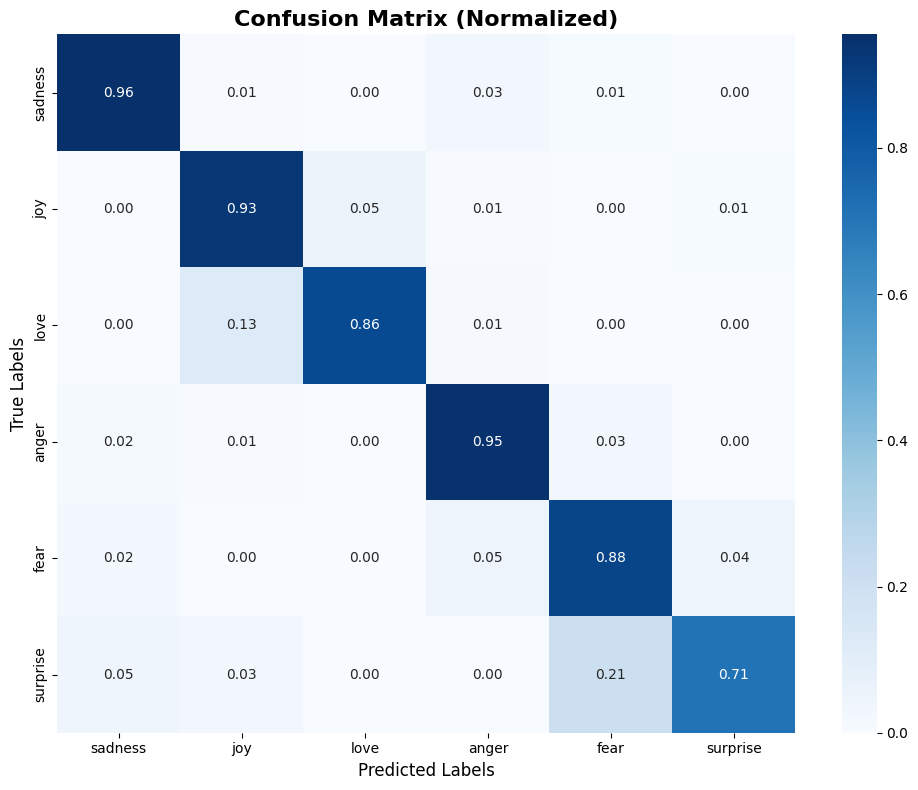

In [30]:
# Get the y_predictions
y_preds_test = np. (preds_output_test.predictions, axis=1)
y_test = np.array(emotion['test']['label'])
label_names = emotion['train'].features['label'].names

# Create normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_preds_test, normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',  # Changed fmt to '.2f' for floats
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()
plt.show()